In [ ]:
%pip install mecab-ko

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [78]:
torch.cuda.init()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.reset_peak_memory_stats(device=None)
# device = 'cpu'  # Force to use CPU for debugging
print("현재 디바이스:", device)


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

현재 디바이스: cpu


In [79]:
# 전처리된 CSV 파일 로드
def load_processed_data(file_path):
    """
    처리된 CSV 파일을 로드하는 함수
    """
    df = pd.read_csv(file_path)
    print(f"로드된 데이터 크기: {df.shape}")
    print(f"컬럼 목록: {df.columns.tolist()}")
    
    # 필요한 열만 추출 (업체명과 클래스)
    result_df = df[['상호명_Regulated', '클래스']].copy()
    
    # 컬럼명 통일
    result_df.columns = ['store', 'classes']
    
    print(f"전처리 후 데이터 크기: {result_df.shape}")
    return result_df

In [80]:
data_df = load_processed_data('./processed_data/seoul_gyeonggi_combined_data.csv')

로드된 데이터 크기: (881212, 5)
컬럼 목록: ['상가업소번호', '지역', '상호명_Regulated', '업종소분류_Regulated', '클래스']
전처리 후 데이터 크기: (881212, 2)


In [81]:
def split_dataset(df, test_size=0.2, random_state=42):
    """
    데이터를 훈련용과 테스트용으로 분할하는 함수
    """
    # 클래스 분포 확인
    num_classes = df['classes'].nunique()
    print(f"고유 클래스 수: {num_classes}")
    
    # 데이터셋 분할 (stratify로 클래스 분포 유지)
    train_df, test_df = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
        stratify=df['classes']
    )
    
    print(f"훈련 데이터 크기: {train_df.shape}")
    print(f"테스트 데이터 크기: {test_df.shape}")

    return train_df, test_df

In [82]:
train_df, test_df = split_dataset(data_df)

고유 클래스 수: 247
훈련 데이터 크기: (704969, 2)
테스트 데이터 크기: (176243, 2)


In [83]:
from konlpy.tag import Mecab

In [84]:
tokenizer = Mecab(dicpath='C:/mecab/mecab-ko-dic')
text = train_df['store'].iloc[0]
tokenizer.nouns(text)

['봉암', '쇼핑']

In [85]:
for i in range(10):
    print(tokenizer.morphs(train_df['store'].iloc[i]))

['봉암', '쇼핑']
['밀사', '랑', '손칼국수']
['지', '케이']
['로그인', '커피']
['영동', '포차', '나']
['삼성', '영어', '수학', '여우', '학원']
['위즈덤', '팩토리']
['케', '듀', '넷']
['키워', '볼래']
['롯데', '리아', '엔제리너스', '경기', '알', '앤', '디비']


In [86]:
token1 = tokenizer.morphs("봉암쇼핑")
token2 = tokenizer.morphs("밀사랑손칼국수")
token3 = tokenizer.morphs("태민건축적산사무소")
token4 = tokenizer.morphs("스타벅스R리저브강남대로점")
token5 = tokenizer.morphs("로그인커피")
token1, token2, token3, token4, token5

(['봉암', '쇼핑'],
 ['밀사', '랑', '손칼국수'],
 ['태민', '건축', '적', '산', '사무소'],
 ['스타', '벅스', 'R', '리저브', '강남대로', '점'],
 ['로그인', '커피'])

In [87]:
train_df

,store,classes
439445,봉암쇼핑,131
868063,밀사랑손칼국수,35
806857,지케이,131
495028,로그인커피,214
244700,영동포차나,95
...,...,...
726190,송희농산,206
485806,풍산우드인테리어,173
209350,태민건축적산사무소,17
703804,운산검도관,222


In [88]:
(x_train, y_train) = train_df.store.to_list(), train_df.classes.to_list()
(x_test, y_test) = test_df.store.to_list(), test_df.classes.to_list()

In [89]:
len(y_train)

704969

In [90]:
x_train

['봉암쇼핑',
 '밀사랑손칼국수',
 '지케이',
 '로그인커피',
 '영동포차나',
 '삼성영어수학여우학원',
 '위즈덤팩토리',
 '케듀넷',
 '키워볼래',
 '롯데리아엔제리너스경기알앤디비',
 '삼성MK공인중개사사무소',
 '그랑컨설팅',
 '폴로노래연습장',
 '술보캠핑포차',
 '광어창고회뜰날',
 '은지애견',
 '건축사사무소나날',
 '노도시스템',
 '엠바이티',
 '수빌리지101동',
 '레슬리영어교실',
 '창고형가구할인마트',
 '삼성에어컨가스충전세척청소이전설치',
 '진심담은된장찌개',
 '핑크버터',
 '이태원동아부동산중개사사무소',
 '생생잉크무한',
 '에코팜서부',
 '케이뷰티 헤어아트',
 '디칼라주얼리카페',
 '비엔피글로벌',
 '원조설렁탕',
 '개포동삼겹살',
 '더블유에스알컴퍼니',
 '법무사이창렬사무소',
 '세무사이준행사무소',
 '백곰수학학원',
 '문봉순대국',
 '남정',
 '유나헤어샵',
 '용수매점',
 '미르플래닝',
 '유한인테리어',
 '버드라이더스딜리버리',
 '종로명가떡집',
 '에이엘켐',
 '법률사무소채움',
 '책나무독서국어학원',
 '쉬기골프아카데미',
 '흙과나무',
 '엔스테인주',
 '불교환경연대',
 '웨딩파트너',
 '포토그레이모란오거리',
 '마크컴퍼니',
 '포즈필라테스',
 '복호두역북점',
 '22펠로톤',
 '매머드익스프레스동안양세무서점',
 '전금희헤어연구소',
 '영환명품크리닝',
 '맞춤정장로체',
 '신라푸드',
 '용인대망포태권도장',
 '어쭈구리왕문어용인',
 '메가엠지씨커피파주초롱꽃',
 '우리동네공인중개사사무소',
 '아티스트태봉',
 '포메인경안',
 '뮤트케이크',
 '화홍집',
 '운석사',
 '이림스타일',
 '강봉구국어교습소',
 '뉴타운부동산신종일공인중개사사무소',
 '블루포트경기대집현관점',
 '역말이동통신',
 '바이모모',
 '실크로드OK마트',
 '일진해외포장',
 '대진카센타',
 '이대푸르지오부동산공인중개사사무소',
 '누나호프',
 '

In [91]:
# 전체 데이터에서 토큰(단어) 사전 구축
all_texts = x_train + x_test
all_tokens = [token for text in all_texts for token in tokenizer.morphs(str(text))]
vocab = {token: idx+1 for idx, token in enumerate(set(all_tokens))}  # 0은 패딩용

In [92]:
# 문장 리스트를 토큰 인덱스 시퀀스로 변환
def texts_to_indices(texts, tokenizer, vocab):
    indices = []
    for text in tqdm(texts):
        tokens = tokenizer.morphs(str(text))
        idx_seq = [vocab.get(token, 0) for token in tokens]  # 없는 토큰은 0
        indices.append(torch.tensor(idx_seq, dtype=torch.long))
    return indices

x_train_indices = texts_to_indices(x_train, tokenizer, vocab)
x_test_indices = texts_to_indices(x_test, tokenizer, vocab)

100%|██████████| 176243/176243 [00:02<00:00, 79614.08it/s]


In [93]:
x_train_indices

[tensor([14112, 82100]),
 tensor([58176,  4974, 60150]),
 tensor([50055, 87059]),
 tensor([39411, 57089]),
 tensor([38139,   791, 24674]),
 tensor([14602, 77679, 70923, 12223, 74300]),
 tensor([ 9381, 23317]),
 tensor([37780, 38489, 44087]),
 tensor([70586, 12173]),
 tensor([88550, 51274, 61196, 24271, 28091, 53965, 74854]),
 tensor([14602,  7090, 37011,  6225, 23230]),
 tensor([11395,  4974, 38892]),
 tensor([ 931, 6877, 2638]),
 tensor([93399, 53129,   791]),
 tensor([ 1616, 78270, 20797, 37417,  9766]),
 tensor([20526, 77745]),
 tensor([25555, 23230, 24674,  9766]),
 tensor([41865, 22894]),
 tensor([83911, 89406]),
 tensor([83948, 35106, 46694, 88436]),
 tensor([76651, 77679, 32505]),
 tensor([74141, 11031, 66600, 87979, 55547]),
 tensor([14602, 61755, 69608, 50086, 31977, 54106, 63235, 12330]),
 tensor([26487, 75658, 15176, 55948]),
 tensor([74148, 50538]),
 tensor([42879,  1339, 45432,  6225, 23230]),
 tensor([34660, 19466, 18222]),
 tensor([94267, 58980,   561]),
 tensor([87059, 

In [94]:
lengths = [len(seq) for seq in x_train_indices]
max_len = max(lengths)
max_len

20

In [95]:
# 패딩
x_train_padded = pad_sequence([seq[:max_len] for seq in x_train_indices], batch_first=True, padding_value=0)
x_test_padded = pad_sequence([seq[:max_len] for seq in x_test_indices], batch_first=True, padding_value=0)

In [96]:
x_train_padded.shape, x_test_padded.shape

(torch.Size([704969, 20]), torch.Size([176243, 20]))

In [97]:
# 임베딩 레이어 테스트
embedding_dim = 128
embedding = nn.Embedding(num_embeddings=len(vocab)+1, embedding_dim=embedding_dim, padding_idx=0)

x_train_embedded = embedding(x_train_padded)  # shape: (batch, max_len, embedding_dim)
x_test_embedded = embedding(x_test_padded)

In [98]:
x_train_embedded.shape, x_test_embedded.shape

(torch.Size([704969, 20, 128]), torch.Size([176243, 20, 128]))

In [103]:
x_train_cnn = x_train_embedded.permute(0, 2, 1)  # shape: (batch, embedding_dim, max_len)
x_test_cnn = x_test_embedded.permute(0, 2, 1)  # shape: (batch, embedding_dim, max_len)
x_train_cnn.shape, x_test_cnn.shape

(torch.Size([704969, 128, 20]), torch.Size([176243, 128, 20]))

In [108]:
class TorchTextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, input_length, filters=250, kernel_size=3, hidden_dims=125, num_classes=247, dropout=0.5):
        super(TorchTextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=filters, kernel_size=kernel_size, padding='valid')
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(filters, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, num_classes)
        
    def forward(self, x):
        x = self.embedding(x)  # (batch, seq_len, embedding_dim)
        x = x.permute(0, 2, 1)  # (batch, embedding_dim, seq_len)
        x = F.relu(self.conv1(x))  # (batch, filters, L_out)
        x = self.global_max_pool(x).squeeze(2)  # (batch, filters)
        x = F.relu(self.fc1(x))  # (batch, hidden_dims)
        x = self.fc2(x)  # (batch, num_classes)
        return x

vocab_size = len(vocab) + 1
embedding_dim = 128
input_length = max_len  # 패딩된 시퀀스 길이
num_classes = 247

model_cnn = TorchTextCNN(vocab_size, embedding_dim, input_length, filters=250, kernel_size=3, hidden_dims=250, num_classes=num_classes).to(device)
print(model_cnn)

TorchTextCNN(
  (embedding): Embedding(95724, 128, padding_idx=0)
  (conv1): Conv1d(128, 250, kernel_size=(3,), stride=(1,), padding=valid)
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=250, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=247, bias=True)
)


In [109]:
# 텐서로 변환 (이미 정수 인코딩된 y_train, y_test 사용)
x_train_tensor = x_train_padded.to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
x_test_tensor = x_test_padded.to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# DataLoader 생성
batch_size = 10
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

In [110]:
num_epochs = 20
history_cnn = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in range(num_epochs):
    model_cnn.train()
    train_loss, train_correct = 0, 0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model_cnn(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
    avg_loss = train_loss / len(train_dataset)
    avg_acc = train_correct / len(train_dataset)
    history_cnn["train_loss"].append(avg_loss)
    history_cnn["train_acc"].append(avg_acc)
    print(f"[Epoch {epoch+1}] Train Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

    # 검증
    model_cnn.eval()
    test_loss, test_correct = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            outputs = model_cnn(x_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * x_batch.size(0)
            preds = outputs.argmax(dim=1)
            test_correct += (preds == y_batch).sum().item()
    avg_test_loss = test_loss / len(test_dataset)
    avg_test_acc = test_correct / len(test_dataset)
    history_cnn["test_loss"].append(avg_test_loss)
    history_cnn["test_acc"].append(avg_test_acc)
    print(f"[Epoch {epoch+1}] Test Loss: {avg_test_loss:.4f} | Test Acc: {avg_test_acc:.4f}")


Epoch 1/20: 100%|██████████| 70497/70497 [36:21<00:00, 32.32it/s]


[Epoch 1] Train Loss: 2.4958 | Train Acc: 0.4892
[Epoch 1] Test Loss: 2.3371 | Test Acc: 0.5159


Epoch 2/20: 100%|██████████| 70497/70497 [41:18<00:00, 28.44it/s]


[Epoch 2] Train Loss: 2.2958 | Train Acc: 0.5215
[Epoch 2] Test Loss: 2.3443 | Test Acc: 0.5157


Epoch 3/20: 100%|██████████| 70497/70497 [41:24<00:00, 28.37it/s]


[Epoch 3] Train Loss: 2.2788 | Train Acc: 0.5237
[Epoch 3] Test Loss: 2.4000 | Test Acc: 0.5117


Epoch 4/20: 100%|██████████| 70497/70497 [41:27<00:00, 28.34it/s]


[Epoch 4] Train Loss: 2.2731 | Train Acc: 0.5239
[Epoch 4] Test Loss: 2.4099 | Test Acc: 0.5112


Epoch 5/20: 100%|██████████| 70497/70497 [41:35<00:00, 28.25it/s]


[Epoch 5] Train Loss: 2.2651 | Train Acc: 0.5234
[Epoch 5] Test Loss: 2.4476 | Test Acc: 0.5094


Epoch 6/20: 100%|██████████| 70497/70497 [41:42<00:00, 28.17it/s]


[Epoch 6] Train Loss: 2.2573 | Train Acc: 0.5242
[Epoch 6] Test Loss: 2.4696 | Test Acc: 0.5028


Epoch 7/20: 100%|██████████| 70497/70497 [41:51<00:00, 28.07it/s]


[Epoch 7] Train Loss: 2.2481 | Train Acc: 0.5262
[Epoch 7] Test Loss: 2.5091 | Test Acc: 0.5070


Epoch 8/20: 100%|██████████| 70497/70497 [42:05<00:00, 27.91it/s]


[Epoch 8] Train Loss: 2.2438 | Train Acc: 0.5260
[Epoch 8] Test Loss: 2.5833 | Test Acc: 0.5031


Epoch 9/20: 100%|██████████| 70497/70497 [42:13<00:00, 27.83it/s]


[Epoch 9] Train Loss: 2.2453 | Train Acc: 0.5264
[Epoch 9] Test Loss: 2.5982 | Test Acc: 0.4928


Epoch 10/20: 100%|██████████| 70497/70497 [42:24<00:00, 27.70it/s]


[Epoch 10] Train Loss: 2.2461 | Train Acc: 0.5256
[Epoch 10] Test Loss: 2.6205 | Test Acc: 0.4936


Epoch 11/20: 100%|██████████| 70497/70497 [42:21<00:00, 27.74it/s]


[Epoch 11] Train Loss: 2.2451 | Train Acc: 0.5254
[Epoch 11] Test Loss: 2.6851 | Test Acc: 0.4985


Epoch 12/20: 100%|██████████| 70497/70497 [42:16<00:00, 27.80it/s]


[Epoch 12] Train Loss: 2.2510 | Train Acc: 0.5247
[Epoch 12] Test Loss: 2.8484 | Test Acc: 0.4922


Epoch 13/20: 100%|██████████| 70497/70497 [42:21<00:00, 27.74it/s]


[Epoch 13] Train Loss: 2.2542 | Train Acc: 0.5250
[Epoch 13] Test Loss: 2.7559 | Test Acc: 0.4958


Epoch 14/20: 100%|██████████| 70497/70497 [42:45<00:00, 27.48it/s]


[Epoch 14] Train Loss: 2.2619 | Train Acc: 0.5245
[Epoch 14] Test Loss: 2.9452 | Test Acc: 0.4812


Epoch 15/20: 100%|██████████| 70497/70497 [42:50<00:00, 27.43it/s]


[Epoch 15] Train Loss: 2.2745 | Train Acc: 0.5241
[Epoch 15] Test Loss: 2.9895 | Test Acc: 0.4686


Epoch 16/20: 100%|██████████| 70497/70497 [42:47<00:00, 27.46it/s]


[Epoch 16] Train Loss: 2.2949 | Train Acc: 0.5201
[Epoch 16] Test Loss: 2.9648 | Test Acc: 0.4725


Epoch 17/20: 100%|██████████| 70497/70497 [43:01<00:00, 27.30it/s]


[Epoch 17] Train Loss: 2.3220 | Train Acc: 0.5163
[Epoch 17] Test Loss: 3.2406 | Test Acc: 0.4881


Epoch 18/20: 100%|██████████| 70497/70497 [43:05<00:00, 27.27it/s]


[Epoch 18] Train Loss: 2.3429 | Train Acc: 0.5133
[Epoch 18] Test Loss: 3.0879 | Test Acc: 0.4620


Epoch 19/20: 100%|██████████| 70497/70497 [42:37<00:00, 27.56it/s]


[Epoch 19] Train Loss: 2.3739 | Train Acc: 0.5094
[Epoch 19] Test Loss: 3.2988 | Test Acc: 0.4252


Epoch 20/20: 100%|██████████| 70497/70497 [42:13<00:00, 27.83it/s]


[Epoch 20] Train Loss: 2.4012 | Train Acc: 0.5068
[Epoch 20] Test Loss: 3.3930 | Test Acc: 0.4456


In [112]:
model_name = 'cnn1d'
time_date = '202505100245'
os.makedirs(f'./saved_model/{model_name}{time_date}', exist_ok=True)
save_path_cnn = f'./saved_model/{model_name}{time_date}/{model_name}{time_date}.pth'

torch.save(model_cnn.state_dict(), save_path_cnn)
pickle.dump(history_cnn, open(f'./saved_model/{model_name}{time_date}/{model_name}{time_date}_history.pkl', 'wb'))

In [137]:
class CNN_LSTM_TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, input_length, filters=128, kernel_size=3, lstm_hidden=128, hidden_dims=125, num_classes=247, dropout=0.3):
        super(CNN_LSTM_TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=filters, kernel_size=kernel_size, padding='same')
        self.lstm = nn.LSTM(input_size=filters, hidden_size=lstm_hidden, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(lstm_hidden, hidden_dims)
        self.fc2 = nn.Linear(hidden_dims, num_classes)

    def forward(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x)  # (batch, seq_len, embedding_dim)
        x = x.permute(0, 2, 1)  # (batch, embedding_dim, seq_len)
        x = F.relu(self.conv1(x))  # (batch, filters, seq_len)
        x = x.permute(0, 2, 1)    # (batch, seq_len, filters) for LSTM
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, lstm_hidden)
        x = lstm_out[:, -1, :]      # 마지막 타임스텝의 출력 사용 (batch, lstm_hidden)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)             # (batch, num_classes)
        return x

# 사용 예시
vocab_size = len(vocab) + 1
embedding_dim = 128
input_length = max_len
num_classes = 247

model_lstm = CNN_LSTM_TextClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    input_length=input_length,
    filters=128,
    kernel_size=3,
    lstm_hidden=128,
    hidden_dims=125,
    num_classes=num_classes,
    dropout=0.3
).to(device)

print(model_lstm)

CNN_LSTM_TextClassifier(
  (embedding): Embedding(95724, 128, padding_idx=0)
  (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same)
  (lstm): LSTM(128, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=128, out_features=125, bias=True)
  (fc2): Linear(in_features=125, out_features=247, bias=True)
)


In [138]:
# 입력 데이터 생성 (패딩된 텐서와 정수 인코딩된 라벨 사용)
x_train_tensor = x_train_padded.to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
x_test_tensor = x_test_padded.to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# DataLoader 생성
batch_size = 10
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

In [ ]:
# 학습 및 검증 결과 저장용 dict
num_epochs = 20
history_lstm = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in range(num_epochs):
    model_lstm.train()
    train_loss, train_correct = 0, 0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model_lstm(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
    avg_loss = train_loss / len(train_dataset)
    avg_acc = train_correct / len(train_dataset)
    history_lstm["train_loss"].append(avg_loss)
    history_lstm["train_acc"].append(avg_acc)
    print(f"[Epoch {epoch+1}] Train Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

    # 검증
    model_lstm.eval()
    test_loss, test_correct = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            outputs = model_lstm(x_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * x_batch.size(0)
            preds = outputs.argmax(dim=1)
            test_correct += (preds == y_batch).sum().item()
    avg_test_loss = test_loss / len(test_dataset)
    avg_test_acc = test_correct / len(test_dataset)
    history_lstm["test_loss"].append(avg_test_loss)
    history_lstm["test_acc"].append(avg_test_acc)
    print(f"[Epoch {epoch+1}] Test Loss: {avg_test_loss:.4f} | Test Acc: {avg_test_acc:.4f}")


Epoch 1/20: 100%|██████████| 70497/70497 [07:31<00:00, 156.17it/s]


[Epoch 1] Train Loss: 2.9054 | Train Acc: 0.3901
[Epoch 1] Test Loss: 2.3413 | Test Acc: 0.5002


Epoch 2/20: 100%|██████████| 70497/70497 [07:31<00:00, 156.21it/s]


[Epoch 2] Train Loss: 2.2673 | Train Acc: 0.5172
[Epoch 2] Test Loss: 2.1861 | Test Acc: 0.5312


Epoch 3/20: 100%|██████████| 70497/70497 [07:30<00:00, 156.33it/s]


[Epoch 3] Train Loss: 2.1402 | Train Acc: 0.5393
[Epoch 3] Test Loss: 2.1165 | Test Acc: 0.5426


Epoch 4/20: 100%|██████████| 70497/70497 [07:31<00:00, 156.27it/s]


[Epoch 4] Train Loss: 2.0740 | Train Acc: 0.5508
[Epoch 4] Test Loss: 2.0747 | Test Acc: 0.5522


Epoch 5/20: 100%|██████████| 70497/70497 [07:30<00:00, 156.32it/s]


[Epoch 5] Train Loss: 2.0316 | Train Acc: 0.5582
[Epoch 5] Test Loss: 2.0584 | Test Acc: 0.5548


Epoch 6/20: 100%|██████████| 70497/70497 [07:32<00:00, 155.96it/s]


[Epoch 6] Train Loss: 1.9982 | Train Acc: 0.5645
[Epoch 6] Test Loss: 2.0432 | Test Acc: 0.5577


Epoch 7/20: 100%|██████████| 70497/70497 [07:31<00:00, 156.20it/s]


[Epoch 7] Train Loss: 1.9756 | Train Acc: 0.5684
[Epoch 7] Test Loss: 2.0248 | Test Acc: 0.5620


Epoch 8/20: 100%|██████████| 70497/70497 [07:31<00:00, 156.30it/s]


[Epoch 8] Train Loss: 1.9554 | Train Acc: 0.5723
[Epoch 8] Test Loss: 2.0202 | Test Acc: 0.5642


Epoch 9/20: 100%|██████████| 70497/70497 [07:31<00:00, 156.21it/s]


[Epoch 9] Train Loss: 1.9405 | Train Acc: 0.5748
[Epoch 9] Test Loss: 2.0227 | Test Acc: 0.5639


Epoch 10/20: 100%|██████████| 70497/70497 [07:31<00:00, 156.01it/s]


[Epoch 10] Train Loss: 1.9290 | Train Acc: 0.5773
[Epoch 10] Test Loss: 2.0094 | Test Acc: 0.5667


Epoch 11/20: 100%|██████████| 70497/70497 [07:31<00:00, 156.27it/s]


[Epoch 11] Train Loss: 1.9198 | Train Acc: 0.5794
[Epoch 11] Test Loss: 2.0090 | Test Acc: 0.5668


Epoch 12/20: 100%|██████████| 70497/70497 [07:31<00:00, 156.05it/s]


[Epoch 12] Train Loss: 1.9129 | Train Acc: 0.5816
[Epoch 12] Test Loss: 2.0165 | Test Acc: 0.5675


Epoch 13/20: 100%|██████████| 70497/70497 [07:31<00:00, 156.17it/s]


[Epoch 13] Train Loss: 1.9071 | Train Acc: 0.5822
[Epoch 13] Test Loss: 2.0178 | Test Acc: 0.5677


Epoch 14/20: 100%|██████████| 70497/70497 [07:31<00:00, 155.98it/s]


[Epoch 14] Train Loss: 1.8972 | Train Acc: 0.5845
[Epoch 14] Test Loss: 2.0138 | Test Acc: 0.5685


Epoch 15/20: 100%|██████████| 70497/70497 [07:31<00:00, 156.17it/s]


[Epoch 15] Train Loss: 1.8969 | Train Acc: 0.5862
[Epoch 15] Test Loss: 2.0106 | Test Acc: 0.5696


Epoch 16/20: 100%|██████████| 70497/70497 [07:32<00:00, 155.90it/s]


[Epoch 16] Train Loss: 1.8908 | Train Acc: 0.5874
[Epoch 16] Test Loss: 2.0097 | Test Acc: 0.5700


Epoch 17/20: 100%|██████████| 70497/70497 [07:31<00:00, 156.05it/s]


[Epoch 17] Train Loss: 1.8838 | Train Acc: 0.5886
[Epoch 17] Test Loss: 2.0370 | Test Acc: 0.5702


Epoch 18/20: 100%|██████████| 70497/70497 [07:31<00:00, 156.05it/s]


[Epoch 18] Train Loss: 1.8905 | Train Acc: 0.5895
[Epoch 18] Test Loss: 2.0411 | Test Acc: 0.5704


Epoch 19/20: 100%|██████████| 70497/70497 [07:31<00:00, 156.12it/s]


[Epoch 19] Train Loss: 1.8874 | Train Acc: 0.5903
[Epoch 19] Test Loss: 2.0537 | Test Acc: 0.5710


Epoch 20/20: 100%|██████████| 70497/70497 [07:31<00:00, 156.13it/s]


[Epoch 20] Train Loss: 1.8765 | Train Acc: 0.5912
[Epoch 20] Test Loss: 2.0509 | Test Acc: 0.5704


In [ ]:
# 모델 저장
save_path_lstm = './saved_model/lstm202505051330/lstm202505051330.pth'
torch.save(model_lstm.state_dict(), save_path_lstm)

In [113]:
history_lstm = {
    "train_loss": [
        2.9054, 2.2673, 2.1402, 2.0740, 2.0316, 1.9982, 1.9756, 1.9554, 1.9405, 1.9290,
        1.9198, 1.9129, 1.9071, 1.8972, 1.8969, 1.8908, 1.8838, 1.8905, 1.8874, 1.8765
    ],
    "train_acc": [
        0.3901, 0.5172, 0.5393, 0.5508, 0.5582, 0.5645, 0.5684, 0.5723, 0.5748, 0.5773,
        0.5794, 0.5816, 0.5822, 0.5845, 0.5862, 0.5874, 0.5886, 0.5895, 0.5903, 0.5912
    ],
    "test_loss": [
        2.3413, 2.1861, 2.1165, 2.0747, 2.0584, 2.0432, 2.0248, 2.0202, 2.0227, 2.0094,
        2.0090, 2.0165, 2.0178, 2.0138, 2.0106, 2.0097, 2.0370, 2.0411, 2.0537, 2.0509
    ],
    "test_acc": [
        0.5002, 0.5312, 0.5426, 0.5522, 0.5548, 0.5577, 0.5620, 0.5642, 0.5639, 0.5667,
        0.5668, 0.5675, 0.5677, 0.5685, 0.5696, 0.5700, 0.5702, 0.5704, 0.5710, 0.5704
    ]
}

In [ ]:
# CNN모델 로드
model_name = 'cnn1d'
time_date = '202505100245'
save_path_cnn = f'./saved_model/{model_name}{time_date}/{model_name}{time_date}.pth'

model_cnn = TorchTextCNN(vocab_size, embedding_dim, input_length, filters=250, kernel_size=3, hidden_dims=125, num_classes=num_classes).to(device)
model_cnn.load_state_dict(torch.load(save_path_cnn))
model_cnn.eval()

TorchTextCNN(
  (embedding): Embedding(95724, 128, padding_idx=0)
  (conv1): Conv1d(128, 250, kernel_size=(3,), stride=(1,), padding=valid)
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=250, out_features=125, bias=True)
  (fc2): Linear(in_features=125, out_features=247, bias=True)
)

In [139]:
# LSTM모델 로드
save_path_lstm = './saved_model/lstm202505051330/lstm202505051330.pth'
model_lstm = CNN_LSTM_TextClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    input_length=input_length,
    filters=128,
    kernel_size=3,
    lstm_hidden=128,
    hidden_dims=125,
    num_classes=num_classes,
    dropout=0.3
).to(device)
model_lstm.load_state_dict(torch.load(save_path_lstm))
model_lstm.eval()

CNN_LSTM_TextClassifier(
  (embedding): Embedding(95724, 128, padding_idx=0)
  (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same)
  (lstm): LSTM(128, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=128, out_features=125, bias=True)
  (fc2): Linear(in_features=125, out_features=247, bias=True)
)

In [117]:
history_cnn["test_acc"], history_lstm["test_acc"]

([0.5159353846677599,
  0.515674381393871,
  0.5116969184591729,
  0.51118058589561,
  0.5093989548521076,
  0.5028341551153804,
  0.5070272294502477,
  0.5031008323734844,
  0.4927628331337982,
  0.49355151693967986,
  0.49854462304885866,
  0.49221813064916053,
  0.4957757187519504,
  0.4812162752563222,
  0.4686427262359356,
  0.47246699159682937,
  0.4881328620143779,
  0.4619871427517689,
  0.425197029101865,
  0.4456233722757783],
 [0.5002,
  0.5312,
  0.5426,
  0.5522,
  0.5548,
  0.5577,
  0.562,
  0.5642,
  0.5639,
  0.5667,
  0.5668,
  0.5675,
  0.5677,
  0.5685,
  0.5696,
  0.57,
  0.5702,
  0.5704,
  0.571,
  0.5704])

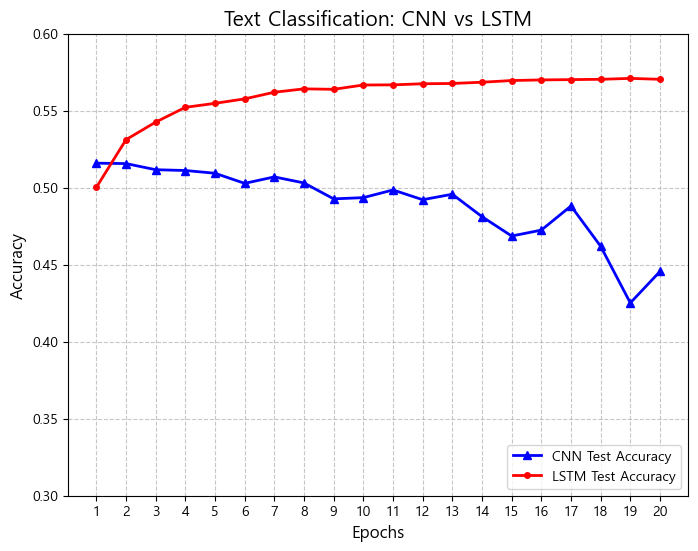

In [126]:
plt.figure(figsize=(8, 6))
plt.plot(history_cnn["test_acc"], 'b^-', label='CNN Test Accuracy', linewidth=2, markersize=6)
plt.plot(history_lstm["test_acc"], 'r.-', label='LSTM Test Accuracy', linewidth=2, markersize=8)

plt.title('Text Classification: CNN vs LSTM', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(20),range(1,21))
plt.ylim(0.3, 0.6)
plt.legend(loc='lower right', fontsize=10, frameon=True)
plt.show()

In [120]:
labels = pickle.load(open('./processed_data/category_mapping.pkl', 'rb'))
labels = {v: k for k, v in labels.items()}
labels

{'0': 'PC방',
 '1': '가구',
 '2': '가발',
 '3': '가방',
 '4': '가스 충전소',
 '5': '가전제품',
 '6': '가전제품 수리',
 '7': '가정용 연료',
 '8': '가죽/가방/신발 수선',
 '9': '가축 사료',
 '10': '간이 음식점(기타)',
 '11': '개인/가정용품 수리(기타)',
 '12': '건강보조식품',
 '13': '건물 및 토목 엔지니어링 서비스',
 '14': '건설/건축자재',
 '15': '건설기계/장비 대여업',
 '16': '건어물/젓갈',
 '17': '건축 설계 및 관련 서비스',
 '18': '건축물 일반 청소',
 '19': '결혼 상담 서비스',
 '20': '경양식',
 '21': '경영 컨설팅',
 '22': '고용 알선업',
 '23': '곡물/곡분',
 '24': '골프 연습장',
 '25': '곱창 전골/구이',
 '26': '공인노무사',
 '27': '공인회계사',
 '28': '광고 대행',
 '29': '광고 매체 판매',
 '30': '광고물 설계/제작업',
 '31': '교육기관(기타)',
 '32': '교육컨설팅',
 '33': '구내식당',
 '34': '국/탕/찌개류',
 '35': '국수/칼국수',
 '36': '기념품점',
 '37': '기숙사/고시원',
 '38': '기타 개인/가정용품 대여업',
 '39': '기타 건설/건축자재',
 '40': '기타 광고 관련 서비스',
 '41': '기타 교육지원 서비스',
 '42': '기타 기술/직업 훈련학원',
 '43': '기타 동남아식 전문',
 '44': '기타 법무관련 서비스',
 '45': '기타 사무 지원 서비스',
 '46': '기타 산업용 기계/장비 대여업',
 '47': '기타 서양식 음식점',
 '48': '기타 스포츠시설 운영업',
 '49': '기타 엔지니어링 서비스',
 '50': '기타 여행 보조/예약 서비스',
 '51': '기타 예술/스포츠 교육기관',
 '52': 

In [140]:
test_result_df = pd.DataFrame(columns = ['store', 'pred_cnn', 'pred_lstm', 'classes', 'label'])
test_result_df['store'] = test_df['store'].copy()
test_result_df['classes'] = test_df['classes'].copy()
test_result_df['label'] = test_result_df['classes'].astype(str).map(labels)
pred_cnn = []
pred_lstm = []
for i in tqdm(range(len(test_result_df))):
    pred_cnn.append(model_cnn(x_test_tensor[i].unsqueeze(0)).argmax(dim=1).item())
    pred_lstm.append(model_lstm(x_test_tensor[i].unsqueeze(0)).argmax(dim=1).item())

test_result_df['pred_cnn'] = pred_cnn
test_result_df['pred_lstm'] = pred_lstm
test_result_df['pred_cnn_label'] = test_result_df['pred_cnn'].astype(str).map(labels)
test_result_df['pred_lstm_label'] = test_result_df['pred_lstm'].astype(str).map(labels)
test_result_df

100%|██████████| 176243/176243 [03:27<00:00, 850.85it/s]


,store,pred_cnn,pred_lstm,classes,label,pred_cnn_label,pred_lstm_label
521619,손끝차이헤어플러스,87,158,87,미용실,미용실,요가/필라테스 학원
684243,와이비오토서비스,184,169,183,자동차 세차장,자동차 정비소,의료기기
491507,에이헤어,87,21,87,미용실,미용실,경영 컨설팅
127752,노보잼,21,91,40,기타 광고 관련 서비스,경영 컨설팅,백반/한정식
77691,인디안미아지점,63,91,151,여성 의류,남성 의류,백반/한정식
693286,박군치킨죽백점,212,91,212,치킨,치킨,백반/한정식
483334,탑K골프,24,21,162,운동용품,골프 연습장,경영 컨설팅
11136,더세컨사이트,21,21,30,광고물 설계/제작업,경영 컨설팅,경영 컨설팅
414007,시화법무사사무소,148,244,94,법무사,약국,화장품
224215,뉴욕포차와치킨클럽,159,91,159,요리 주점,요리 주점,백반/한정식


In [141]:
errors_cnn_df = test_result_df[test_result_df['pred_cnn'] != test_result_df['classes']][['store', 'pred_cnn_label', 'label']]
errors_cnn_df = errors_cnn_df.reset_index(drop=True)
errors_cnn_df.head(20)

,store,pred_cnn_label,label
0,와이비오토서비스,자동차 정비소,자동차 세차장
1,노보잼,경영 컨설팅,기타 광고 관련 서비스
2,인디안미아지점,남성 의류,여성 의류
3,탑K골프,골프 연습장,운동용품
4,더세컨사이트,경영 컨설팅,광고물 설계/제작업
5,시화법무사사무소,약국,법무사
6,제이엠인터내셔널,경영 컨설팅,변리사
7,우리중량,약국,기타 엔지니어링 서비스
8,더아이엔지투어주,부동산 중개/대리,여행사
9,녹향원,백반/한정식,횟집


In [142]:
errors_lstm_df = test_result_df[test_result_df['pred_lstm'] != test_result_df['classes']][['store', 'pred_lstm_label', 'label']]
errors_lstm_df = errors_lstm_df.reset_index(drop=True)
errors_lstm_df.head(20)

,store,pred_lstm_label,label
0,손끝차이헤어플러스,요가/필라테스 학원,미용실
1,와이비오토서비스,의료기기,자동차 세차장
2,에이헤어,경영 컨설팅,미용실
3,노보잼,백반/한정식,기타 광고 관련 서비스
4,인디안미아지점,백반/한정식,여성 의류
5,박군치킨죽백점,백반/한정식,치킨
6,탑K골프,경영 컨설팅,운동용품
7,더세컨사이트,경영 컨설팅,광고물 설계/제작업
8,시화법무사사무소,화장품,법무사
9,뉴욕포차와치킨클럽,백반/한정식,요리 주점


In [143]:
acc_cnn = (test_result_df['pred_cnn'] == test_result_df['classes']).mean() * 100
print(f"cnn 정확도: {acc_cnn:.2f}%")
acc_lstm = (test_result_df['pred_lstm'] == test_result_df['classes']).mean() * 100
print(f"lstm 정확도: {acc_lstm:.2f}%")

cnn 정확도: 44.56%
lstm 정확도: 2.91%


In [144]:
model_name = 'cnn1d'
time_date = '202505100245'
pickle.dump(test_result_df, open(f'./saved_model/{model_name}{time_date}/test_result_df.pkl', 'wb'))
pickle.dump(errors_cnn_df, open(f'./saved_model/{model_name}{time_date}/errors_cnn_df.pkl', 'wb'))
pickle.dump(errors_lstm_df, open(f'./saved_model/lstm202505051330/errors_lstm_df.pkl', 'wb'))

In [26]:
model_name = 'cnn1d'
time_date = '202505051330'
test_result_df = pickle.load(open(f'./saved_model/{model_name}{time_date}/test_result_df.pkl', 'rb'))
errors_cnn_df = pickle.load(open(f'./saved_model/{model_name}{time_date}/errors_cnn_df.pkl', 'rb'))
errors_lstm_df = pickle.load(open('./saved_model/lstm202505051330/errors_lstm_df.pkl', 'rb'))
test_result_df.head(20)

,store,pred_cnn,pred_lstm,classes,label,pred_cnn_label,pred_lstm_label
521619,손끝차이헤어플러스,87,87,87,미용실,미용실,미용실
684243,와이비오토서비스,24,184,183,자동차 세차장,골프 연습장,자동차 정비소
491507,에이헤어,87,87,87,미용실,미용실,미용실
127752,노보잼,21,91,40,기타 광고 관련 서비스,경영 컨설팅,백반/한정식
77691,인디안미아지점,55,55,151,여성 의류,기타 의류,기타 의류
693286,박군치킨죽백점,212,212,212,치킨,치킨,치킨
483334,탑K골프,184,162,162,운동용품,자동차 정비소,운동용품
11136,더세컨사이트,21,21,30,광고물 설계/제작업,경영 컨설팅,경영 컨설팅
414007,시화법무사사무소,94,94,94,법무사,법무사,법무사
224215,뉴욕포차와치킨클럽,159,159,159,요리 주점,요리 주점,요리 주점


In [338]:
len(test_result_df) , len(errors_cnn_df), len(errors_lstm_df)

(176243, 102243, 75725)

In [339]:
# CNN 오분류 쌍별로 등장 횟수 집계
cnn_case_counts = (
    errors_cnn_df.groupby(['pred_cnn_label', 'label'])
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)
cnn_case_counts.head(10)

,pred_cnn_label,label,count
316,경영 컨설팅,광고 대행,2495
2152,슈퍼마켓,백반/한정식,1380
1684,백반/한정식,카페,1286
2098,슈퍼마켓,국/탕/찌개류,1108
384,경영 컨설팅,부동산 중개/대리,1100
480,경영 컨설팅,카페,1061
1635,백반/한정식,요리 주점,1054
410,경영 컨설팅,시각 디자인업,985
1563,백반/한정식,돼지고기 구이/찜,940
342,경영 컨설팅,기타 의류,857


In [340]:
# LSTM 오분류 쌍별로 등장 횟수 집계
lstm_case_counts = (
    errors_lstm_df.groupby(['pred_lstm_label', 'label'])
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)
lstm_case_counts.head(10)

,pred_lstm_label,label,count
879,경영 컨설팅,광고 대행,1017
3168,백반/한정식,돼지고기 구이/찜,931
948,경영 컨설팅,부동산 중개/대리,697
3240,백반/한정식,요리 주점,615
3291,백반/한정식,카페,498
7212,카페,백반/한정식,483
1229,광고 대행,경영 컨설팅,474
1044,경영 컨설팅,카페,412
7267,카페,요리 주점,402
7224,카페,빵/도넛,396


---

### CNN confusion matrix

In [341]:
# confusion matrix 생성
unique_classes = sorted(test_result_df['classes'].unique())
y_true = test_result_df['classes'].astype(int)
y_pred = test_result_df['pred_cnn'].astype(int)
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
cm_df = pd.DataFrame(cm)

cm_df.head(10)

# 클래스명 매핑
class_labels = [labels[str(idx)] for idx in unique_classes]

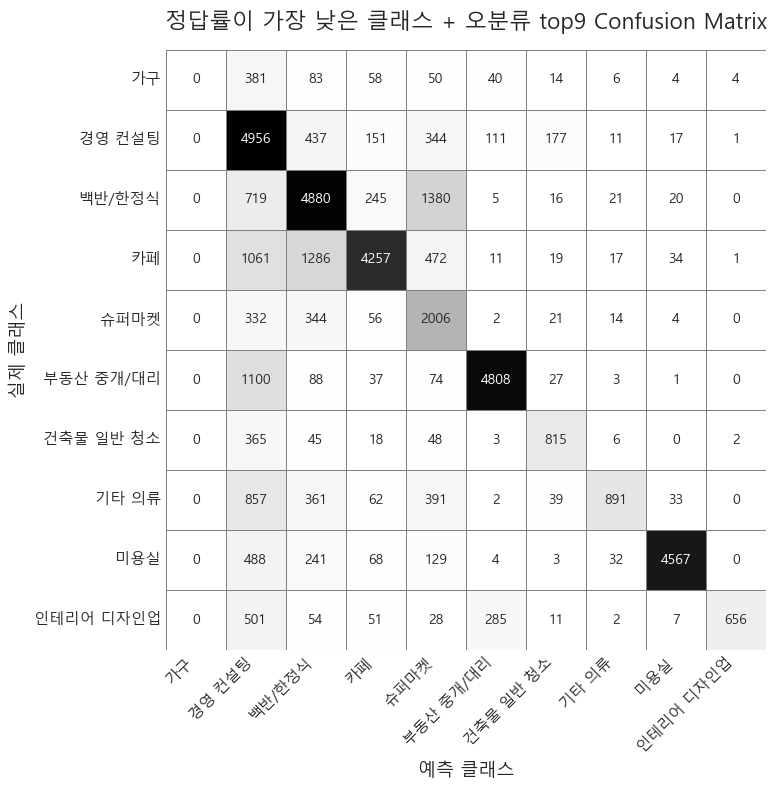

In [342]:
total_counts = cm.sum(axis=1)
correct_counts = np.diag(cm)
correct_ratio = correct_counts / (total_counts + 1e-8)

# 정답률이 가장 낮은 클래스 인덱스
low_idx = np.argmin(correct_ratio)
low_class = unique_classes[low_idx]

# 해당 클래스에서 오분류가 가장 많은 9개 클래스 인덱스(자기 자신 제외)
row = cm[low_idx].copy()
row[low_idx] = 0
top9_wrong_idx = np.argsort(row)[-9:][::-1]

selected_idx = [low_idx] + list(top9_wrong_idx)
cm_sub = cm[np.ix_(selected_idx, selected_idx)]
class_labels = [labels[str(unique_classes[i])] for i in selected_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_sub,
            annot=True,
            fmt='d',
            cmap='Greys',
            xticklabels=class_labels,
            yticklabels=class_labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False,
            square=True
            )
plt.title('정답률이 가장 낮은 클래스 + 오분류 top9 Confusion Matrix', fontsize=16, pad=15)
plt.xlabel('예측 클래스', fontsize=13)
plt.ylabel('실제 클래스', fontsize=13)
plt.xticks(fontsize=11, rotation=45, ha='right')
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
plt.show()

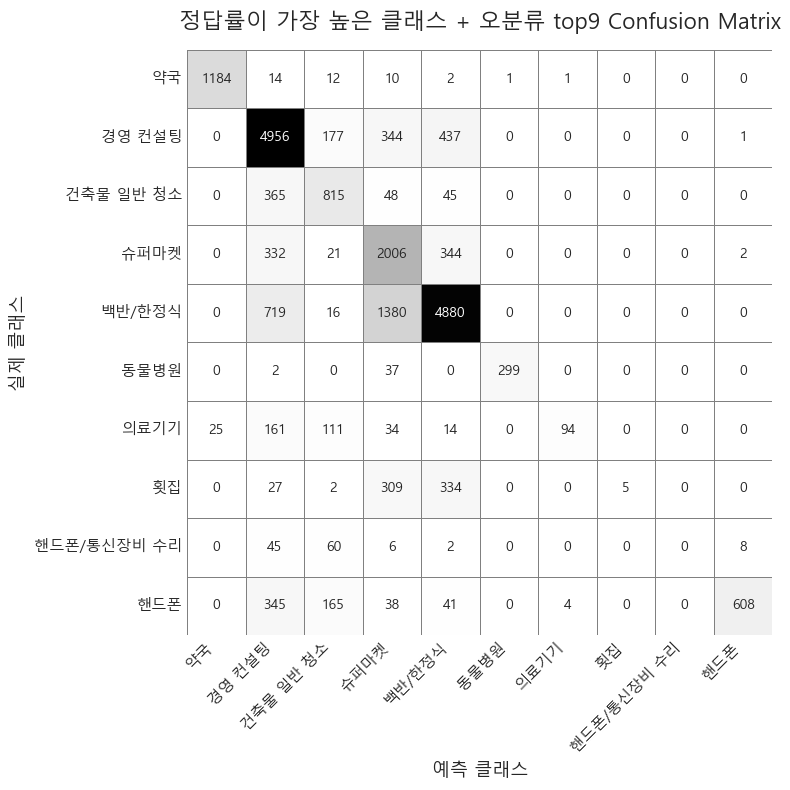

In [350]:
total_counts = cm.sum(axis=1)
correct_counts = np.diag(cm)
correct_ratio = correct_counts / (total_counts + 1e-8)

top_idx = np.argmax(correct_ratio)
top_class = unique_classes[top_idx]

row = cm[top_idx].copy()
row[top_idx] = 0  # 자기 자신 제외
top9_wrong_idx = np.argsort(row)[-9:][::-1]

selected_idx = [top_idx] + list(top9_wrong_idx)
cm_sub = cm[np.ix_(selected_idx, selected_idx)]
class_labels = [labels[str(unique_classes[i])] for i in selected_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_sub,
            annot=True,
            fmt='d',
            cmap='Greys',
            xticklabels=class_labels,
            yticklabels=class_labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False,
            square=True
            )
plt.title('정답률이 가장 높은 클래스 + 오분류 top9 Confusion Matrix', fontsize=16, pad=15)
plt.xlabel('예측 클래스', fontsize=13)
plt.ylabel('실제 클래스', fontsize=13)
plt.xticks(fontsize=11, rotation=45, ha='right')
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
plt.show()

In [344]:
test_result_cnn_furniture_df = test_result_df[(test_result_df['label'] == '가구')][['store', 'pred_cnn_label', 'label']]
test_result_cnn_furniture_df.head(30)

,store,pred_cnn_label,label
880858,올리브엔제펫토,기타 의류,가구
537228,에이치제이궁,경영 컨설팅,가구
248377,더블유맨션,백반/한정식,가구
572737,매니아베드,경영 컨설팅,가구
476239,대박가구아울렛,경영 컨설팅,가구
592567,삼진앤틱가구,경영 컨설팅,가구
518279,분당가구타운,카페,가구
361312,모베,백반/한정식,가구
101309,잠실나의부엌,백반/한정식,가구
558417,소희가구갤러리,경영 컨설팅,가구


In [348]:
test_result_cnn_arcade_df = test_result_df[(test_result_df['label'] == '약국')][['store', 'pred_cnn_label', 'label']]
test_result_cnn_arcade_df.head(30)

,store,pred_cnn_label,label
349615,롯데온누리약국,약국,약국
775293,정문온누리약국,약국,약국
106094,마곡소망약국,약국,약국
423286,금파약국,약국,약국
393264,희전약국,약국,약국
415726,백제온누리약국,약국,약국
20679,발산그랜드약국,약국,약국
67900,태릉프라자약국,약국,약국
155181,이로운약국,약국,약국
394444,풍동메디칼약국,약국,약국


---
### LSTM Confusion matrix

In [149]:
unique_classes = sorted(test_result_df['classes'].unique())
y_true = test_result_df['classes'].astype(int)
y_pred_lstm = test_result_df['pred_lstm'].astype(int)
cm_lstm = confusion_matrix(y_true, y_pred_lstm, labels=unique_classes)
cm_lstm_df = pd.DataFrame(cm_lstm)
cm_lstm_df

class_labels = [labels[str(idx)] for idx in unique_classes]


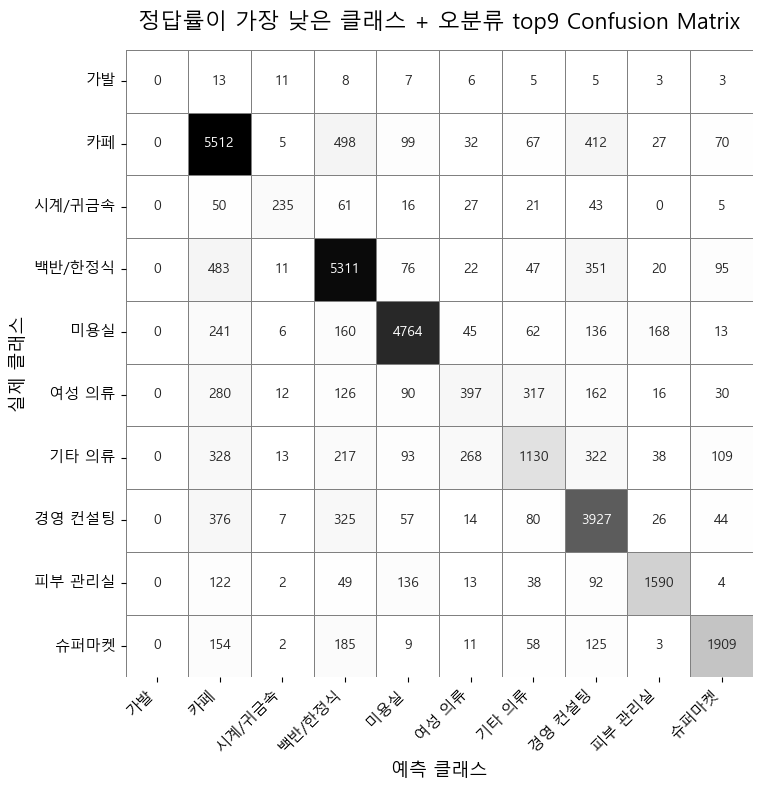

In [ ]:
total_counts = cm_lstm.sum(axis=1)
correct_counts = np.diag(cm_lstm)
correct_ratio = correct_counts / (total_counts + 1e-8)

# 정답률이 가장 낮은 클래스 인덱스
low_idx = np.argmin(correct_ratio)
low_class = unique_classes[low_idx]

# 해당 클래스에서 오분류가 가장 많은 9개 클래스 인덱스(자기 자신 제외)
row = cm_lstm[low_idx].copy()
row[low_idx] = 0
top9_wrong_idx = np.argsort(row)[-9:][::-1]

selected_idx = [low_idx] + list(top9_wrong_idx)
cm_sub = cm_lstm[np.ix_(selected_idx, selected_idx)]
class_labels = [labels[str(unique_classes[i])] for i in selected_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_sub,
            annot=True,
            fmt='d',
            cmap='Greys',
            xticklabels=class_labels,
            yticklabels=class_labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False,
            square=True
            )
plt.title('정답률이 가장 낮은 클래스 + 오분류 top9 Confusion Matrix', fontsize=16, pad=15)
plt.xlabel('예측 클래스', fontsize=13)
plt.ylabel('실제 클래스', fontsize=13)
plt.xticks(fontsize=11, rotation=45, ha='right')
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
plt.show()

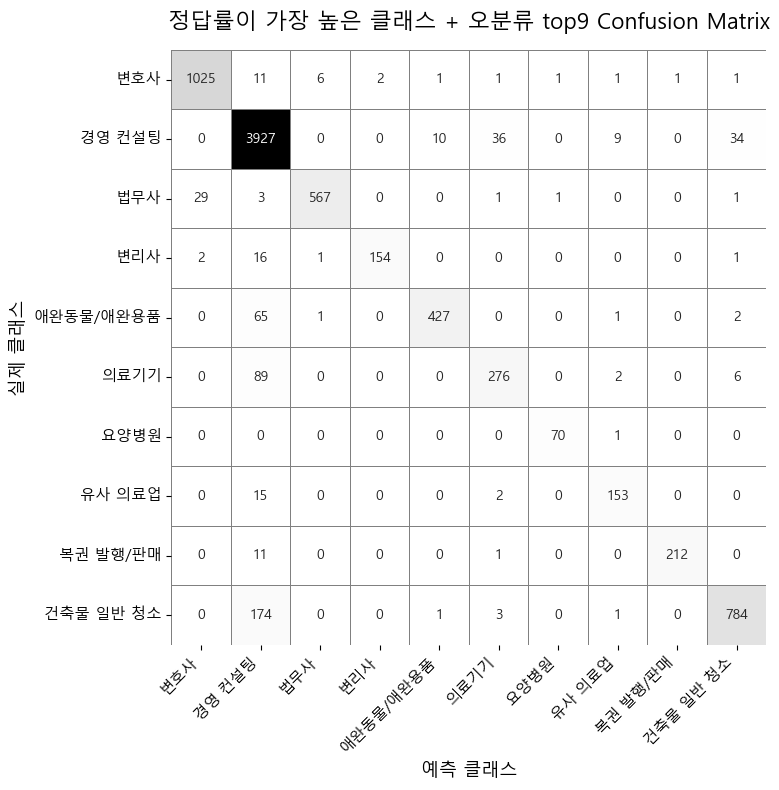

In [ ]:
total_counts = cm_lstm.sum(axis=1)
correct_counts = np.diag(cm_lstm)
correct_ratio = correct_counts / (total_counts + 1e-8)

top_idx = np.argmax(correct_ratio)
top_class = unique_classes[top_idx]

row = cm_lstm[top_idx].copy()
row[top_idx] = 0  # 자기 자신 제외
top9_wrong_idx = np.argsort(row)[-9:][::-1]

selected_idx = [top_idx] + list(top9_wrong_idx)
cm_sub = cm_lstm[np.ix_(selected_idx, selected_idx)]
class_labels = [labels[str(unique_classes[i])] for i in selected_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_sub,
            annot=True,
            fmt='d',
            cmap='Greys',
            xticklabels=class_labels,
            yticklabels=class_labels,
            linewidths=0.5,
            linecolor='gray',
            cbar=False,
            square=True
            )
plt.title('정답률이 가장 높은 클래스 + 오분류 top9 Confusion Matrix', fontsize=16, pad=15)
plt.xlabel('예측 클래스', fontsize=13)
plt.ylabel('실제 클래스', fontsize=13)
plt.xticks(fontsize=11, rotation=45, ha='right')
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
test_result_lstm_wig_df = test_result_df[(test_result_df['label'] == '가발')][['store', 'pred_lstm_label', 'label']]
test_result_lstm_wig_df

,store,pred_lstm_label,label
754554,모처럼,경영 컨설팅,가발
844350,에이치스랩,광고 대행,가발
155272,용재교역,핸드폰,가발
844252,아쿠아잼,안경렌즈,가발
352375,앱포스터타임플릭성수,광고 대행,가발
...,...,...,...
342651,NMBRREDROOM2F,백반/한정식,가발
764003,별찌용인외대점,백반/한정식,가발
766676,또롱,카페,가발
349775,로미피어싱,여성 의류,가발


In [ ]:
test_result_lstm_laywer_df = test_result_df[(test_result_df['label'] == '변호사')][['store', 'pred_lstm_label', 'label']]
test_result_lstm_laywer_df

,store,pred_lstm_label,label
370917,변호사박국병법률사무소,변호사,변호사
89583,한성국제법률사무소,변호사,변호사
90345,박광오법률사무소,변호사,변호사
340403,법률사무소덕,변호사,변호사
57977,법무법인중용,변호사,변호사
...,...,...,...
5486,송순권법무사사무소,법무사,변호사
161939,탑법률사무소,변호사,변호사
289706,법무법인비에이치에스엔,변호사,변호사
284085,변호사이종호법률사무소,변호사,변호사


In [35]:
def plot_nth_lowest_accuracy_confusion_label(cm, unique_labels, n=1, topk=9):
    """
    cm: confusion_matrix (numpy array, label 순서)
    unique_labels: label(문자열) 리스트 (confusion_matrix의 labels 순서와 동일)
    n: 정답률이 낮은 순서에서 n번째 (1부터 시작)
    topk: 오분류 top k개
    """
    total_counts = cm.sum(axis=1)
    correct_counts = np.diag(cm)
    correct_ratio = correct_counts / (total_counts + 1e-8)

    # 정답률 낮은 순서대로 인덱스 정렬
    sorted_idx = np.argsort(correct_ratio)
    nth_idx = sorted_idx[n-1]  # n=1이면 가장 낮은 클래스

    row = cm[nth_idx].copy()
    row[nth_idx] = 0  # 자기 자신 제외
    topk_wrong_idx = np.argsort(row)[-topk:][::-1]

    selected_idx = [nth_idx] + list(topk_wrong_idx)
    cm_sub = cm[np.ix_(selected_idx, selected_idx)]
    class_labels = [unique_labels[i] for i in selected_idx]

    if n <= 0:
        title = f'{abs(n)+1}번째로 정답률이 높은 클래스 + 오분류 top{topk} Confusion Matrix'
    else:
        title = f'{n}번째로 정답률이 낮은 클래스 + 오분류 top{topk} Confusion Matrix'
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_sub,
                annot=True,
                fmt='d',
                cmap='Greys',
                xticklabels=class_labels,
                yticklabels=class_labels,
                linewidths=0.5,
                linecolor='gray',
                cbar=False,
                square=True
                )
    ax = plt.gca()
    for spine in ['right', 'bottom']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_linewidth(1)
        ax.spines[spine].set_color('gray')
    plt.title(title, fontsize=16, pad=15, x=0.27)
    plt.xlabel('예측 클래스', fontsize=13)
    plt.ylabel('실제 클래스', fontsize=13)
    plt.xticks(fontsize=11, rotation=45, ha='right')
    plt.yticks(fontsize=11, rotation=0)
    plt.tight_layout()
    plt.show()

In [37]:
# label(문자열) 기준 confusion matrix 생성
unique_labels = sorted(test_result_df['label'].unique())
y_true = test_result_df['label']
y_pred = test_result_df['pred_lstm_label']
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

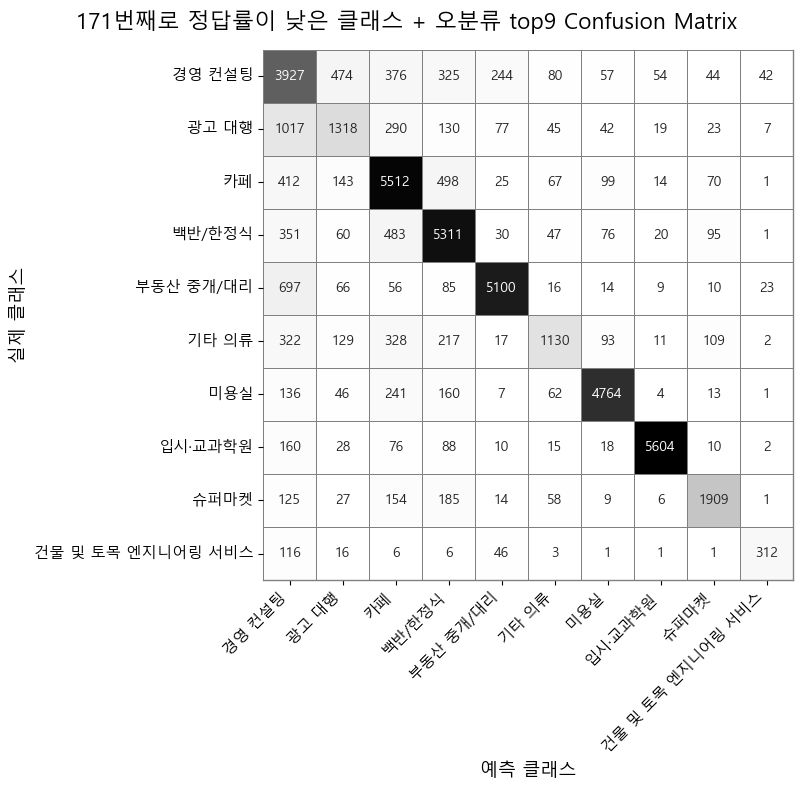

In [43]:
plot_nth_lowest_accuracy_confusion_label(cm, unique_labels, n=171, topk=9)

In [ ]:
test_result_lstm_e1 = test_result_df[(test_result_df['label'] == '광고 대행') & (test_result_df['pred_lstm_label'] == '경영 컨설팅')][['store', 'pred_lstm_label', 'label']]
test_result_lstm_e1

,store,pred_lstm_label,label
577253,제이앤씨프라퍼티,경영 컨설팅,광고 대행
814055,성공신화,경영 컨설팅,광고 대행
543934,엠아이앤,경영 컨설팅,광고 대행
449457,케이오케이,경영 컨설팅,광고 대행
185737,일이이육컴퍼니,경영 컨설팅,광고 대행
...,...,...,...
105184,디케이비즈니스센터,경영 컨설팅,광고 대행
296324,세이브머니,경영 컨설팅,광고 대행
155807,현남,경영 컨설팅,광고 대행
516309,필앤굿,경영 컨설팅,광고 대행


In [ ]:
test_result_lstm_e1_true = test_result_df[(test_result_df['label'] == '경영 컨설팅')|
                                          (test_result_df['label'] == '광고 대행')
                                          ][['store', 'pred_lstm_label', 'label']]
test_result_lstm_e1_true

,store,pred_lstm_label,label
577253,제이앤씨프라퍼티,경영 컨설팅,광고 대행
207581,국가창업전략연구원,경영 컨설팅,경영 컨설팅
751030,스쿨애드,광고 대행,광고 대행
632980,라팜,채소/과일,경영 컨설팅
814055,성공신화,경영 컨설팅,광고 대행
...,...,...,...
271926,스타웰,경영 컨설팅,경영 컨설팅
603903,알에이치마케팅,광고 대행,광고 대행
834313,애드커넥트,광고 대행,광고 대행
828076,블룸즈버리,백반/한정식,경영 컨설팅


In [ ]:
test_result_lstm_e2_true = test_result_df[(test_result_df['label'] == '백반/한정식')|
                                          (test_result_df['label'] == '돼지고기 구이/찜')|
                                          (test_result_df['label'] == '요리 주점')
                                          ][['store', 'pred_lstm_label', 'label']]
test_result_lstm_e2_true

,store,pred_lstm_label,label
224215,뉴욕포차와치킨클럽,요리 주점,요리 주점
252765,달빛수라,백반/한정식,백반/한정식
407298,밤듸농원,꽃집,돼지고기 구이/찜
615336,아크에프앤씨,경영 컨설팅,백반/한정식
696495,풍무연탄집,백반/한정식,백반/한정식
...,...,...,...
617129,땡삼,백반/한정식,돼지고기 구이/찜
338700,명가어반,백반/한정식,백반/한정식
815744,만석골,백반/한정식,백반/한정식
759166,세라젬웰카페시흥,백반/한정식,백반/한정식


In [ ]:
test_result_lstm_e3 = test_result_df[(test_result_df['label'] == '카페')|
                                    (test_result_df['label'] == '빵/도넛')
                                    ][['store', 'pred_lstm_label', 'label']]
test_result_lstm_e3

,store,pred_lstm_label,label
133568,지향디저트,카페,빵/도넛
553049,별콩카페,카페,카페
750237,카페란떼,카페,카페
572596,맬봄제과,빵/도넛,빵/도넛
121265,쥬씨현대,카페,카페
...,...,...,...
56698,카페시모대방점,카페,카페
520107,나화너,경양식,카페
752242,행궁커피숍,카페,카페
129720,폴드,카페,카페


In [24]:
from sklearn.metrics import classification_report
print(classification_report(test_result_df['label'], test_result_df['pred_cnn_label'], digits=4, zero_division=0))


                      precision    recall  f1-score   support

                 PC방     0.9414    0.6509    0.7696       444
                  가구     0.7310    0.3222    0.4473       658
                  가발     0.0000    0.0000    0.0000        84
                  가방     0.0000    0.0000    0.0000       333
              가스 충전소     0.3333    0.0204    0.0385        98
                가전제품     0.1038    0.0229    0.0375       480
             가전제품 수리     0.4476    0.4036    0.4245       773
              가정용 연료     0.3592    0.2164    0.2701       171
         가죽/가방/신발 수선     0.0000    0.0000    0.0000        82
               가축 사료     0.0000    0.0000    0.0000        73
          간이 음식점(기타)     0.9091    0.0210    0.0410       477
      개인/가정용품 수리(기타)     0.3866    0.1722    0.2383       604
              건강보조식품     0.3654    0.1696    0.2317      1008
   건물 및 토목 엔지니어링 서비스     0.3854    0.0585    0.1016       632
             건설/건축자재     0.0000    0.0000    0.0000        72
       

In [27]:
print(classification_report(test_result_df['label'], test_result_df['pred_lstm_label'], digits=4, zero_division=0))

                      precision    recall  f1-score   support

                 PC방     0.8704    0.8018    0.8347       444
                  가구     0.6397    0.3723    0.4707       658
                  가발     0.0000    0.0000    0.0000        84
                  가방     0.6250    0.0901    0.1575       333
              가스 충전소     0.6627    0.5612    0.6077        98
                가전제품     0.0825    0.0167    0.0277       480
             가전제품 수리     0.3495    0.4955    0.4098       773
              가정용 연료     0.7111    0.5614    0.6275       171
         가죽/가방/신발 수선     1.0000    0.0122    0.0241        82
               가축 사료     0.0000    0.0000    0.0000        73
          간이 음식점(기타)     0.5306    0.0545    0.0989       477
      개인/가정용품 수리(기타)     0.5340    0.2864    0.3728       604
              건강보조식품     0.3644    0.4226    0.3914      1008
   건물 및 토목 엔지니어링 서비스     0.3190    0.4937    0.3876       632
             건설/건축자재     0.3030    0.2778    0.2899        72
       